# Automatically generating object masks with SAM

This notebook shows how to segment objects from an image using the Segment Anything Model (SAM) with a few lines of code. Make sure you use GPU runtime for this notebook. GPU Memory should > 2GB Free.

## Prepare Working Directory

In [1]:
# Import the os module
import os

path = 'tmp/'

try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except NotADirectoryError:
    print("{0} is not a directory".format(path))
except PermissionError:
    print("You do not have permissions to change to {0}".format(path))

Current working directory: /home/ec2-user/SageMaker/ODP_Demo/tmp


## Import Libaray

In [2]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

## Create an interactive map

In [3]:
m = leafmap.Map(center=[37.8713, -122.2580], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m.attribution_control=False
m

Map(center=[37.8713, -122.258], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…


Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [4]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-122.2659, 37.8682, -122.2521, 37.8741]

## Download a sample image

In [5]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 01/24
Downloaded image 02/24
Downloaded image 03/24
Downloaded image 04/24
Downloaded image 05/24
Downloaded image 06/24
Downloaded image 07/24
Downloaded image 08/24
Downloaded image 09/24
Downloaded image 10/24
Downloaded image 11/24
Downloaded image 12/24
Downloaded image 13/24
Downloaded image 14/24
Downloaded image 15/24
Downloaded image 16/24
Downloaded image 17/24
Downloaded image 18/24
Downloaded image 19/24
Downloaded image 20/24
Downloaded image 21/24
Downloaded image 22/24
Downloaded image 23/24
Downloaded image 24/24
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


You can also use your own image. Uncomment and run the following cell to use your own image.

In [6]:
# image = '/path/to/your/own/image.tif'

Display the downloaded image on the map.

In [7]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(center=[37.8713, -122.258], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

## Initialize SAM class

Clear CUDA Memory

In [8]:
import torch
torch.cuda.empty_cache()

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [9]:
out_dir = os.path.join(os.path.expanduser("~"), "Downloads")
checkpoint = os.path.join(out_dir, "sam_vit_h_4b8939.pth")

In [10]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=None,
)

## Mask 1 Automatic Generation (Typical)

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object. 

In [11]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

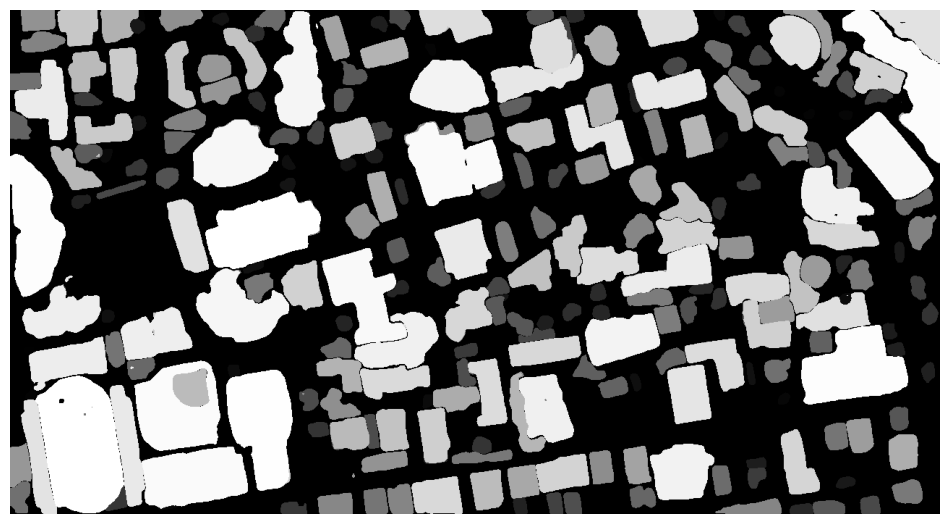

In [12]:
sam.show_masks(cmap="binary_r")

Show the object annotations (objects with random color) on the map.

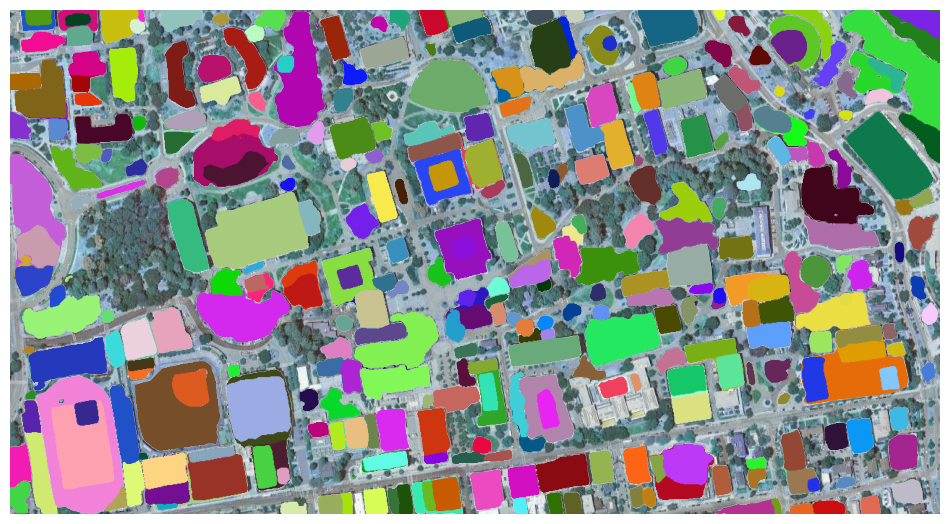

In [13]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

### Compare images with a slider & generate html as output


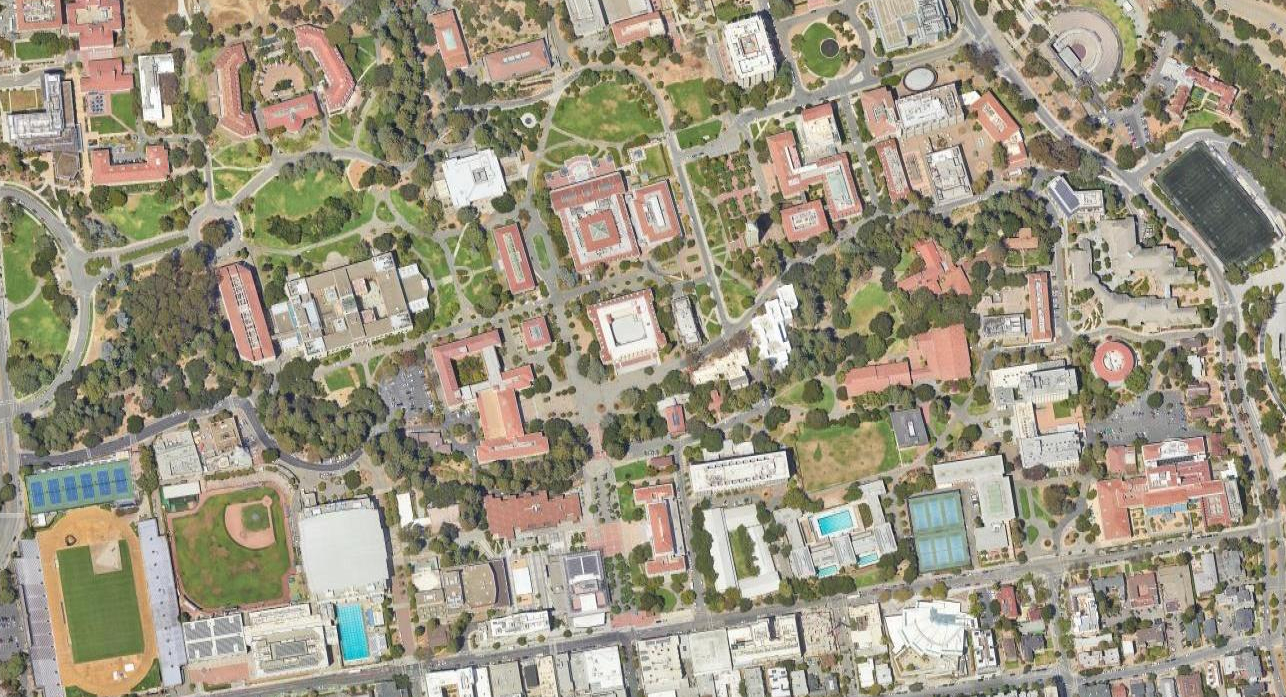
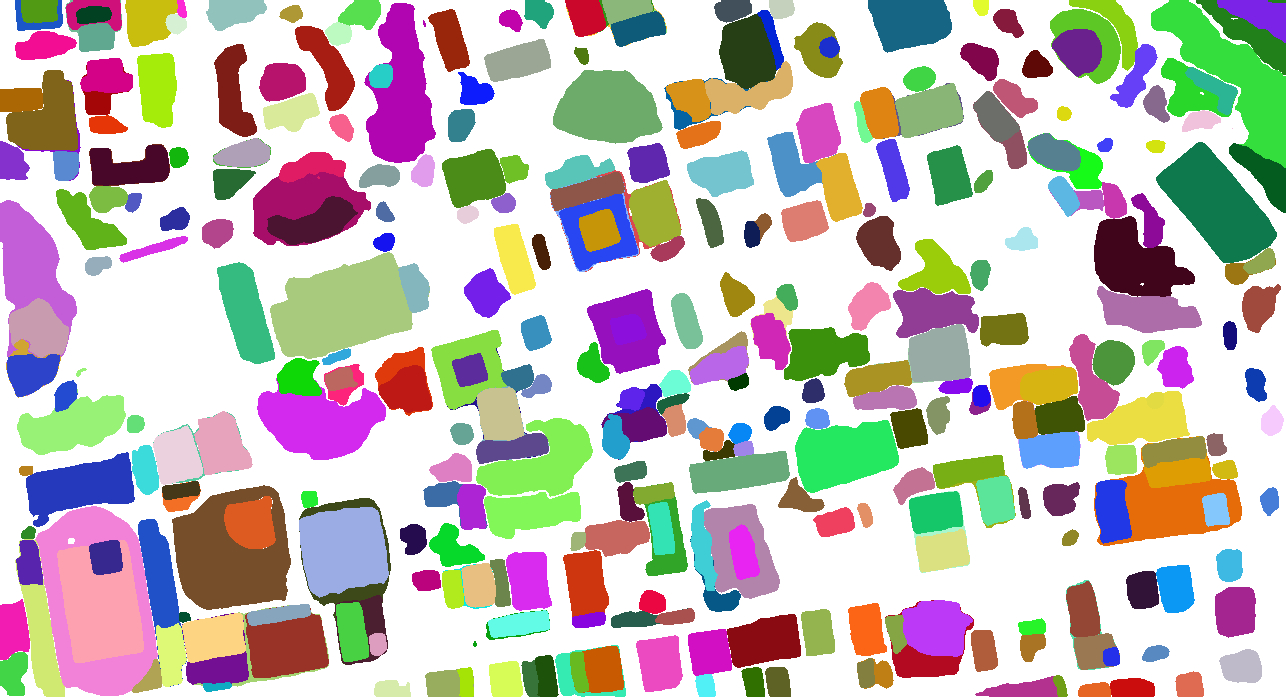

In [14]:
img1 = "satellite.tif"
img2 = "annotations.tif"

leafmap.image_comparison(
    img1,
    img2,
    label1="Satellite Image",
    label2="Image Segmentation",
    starting_position=50,
    out_html='sam_comparison.html',
)

### Add image & vector to the map

In [15]:
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

Map(center=[37.8713, -122.258], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Convert the object annotations to vector format, such as GeoPackage, Shapefile, or GeoJSON.

In [16]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")

## Mask 2 Automatic Generation (optional)

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [17]:
import torch
torch.cuda.empty_cache()

In [18]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [19]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=sam_kwargs,
)

In [20]:
sam.generate(image, output="masks2.tif", foreground=True)

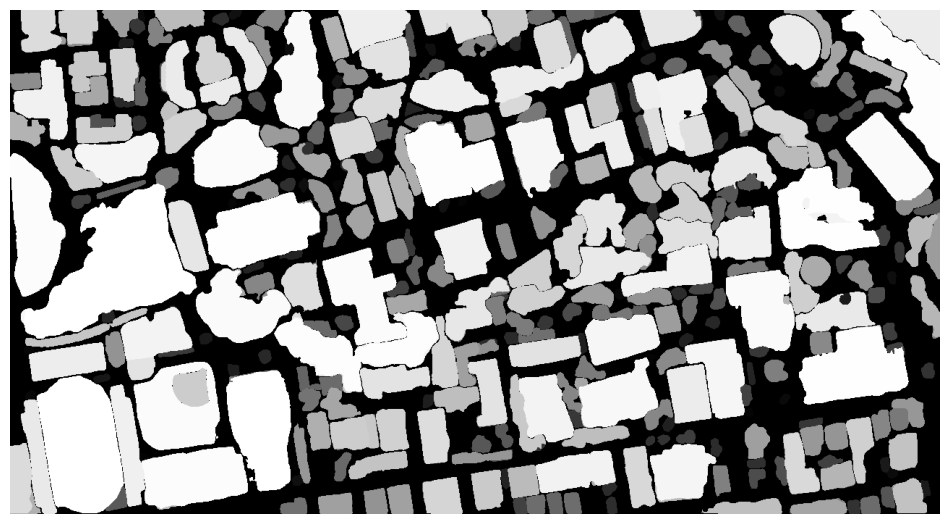

In [21]:
sam.show_masks(cmap="binary_r")

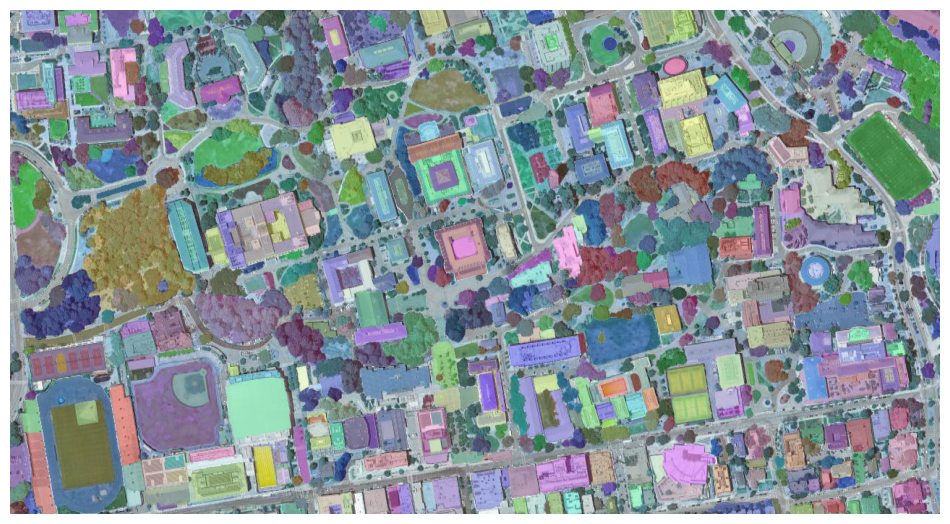

In [22]:
sam.show_anns(axis="off", opacity=1, output="annotations2.tif")

## Polygonize the raster data
Save the segmentation results as a GeoPackage file.

In [23]:
mask2 = "masks2.tif"

In [24]:
vector = "segment.gpkg"
sam.tiff_to_gpkg(mask2, vector, simplify_tolerance=None)

You can also save the segmentation results as any vector data format supported by GeoPandas.

In [25]:
shapefile = "segment.shp"
sam.tiff_to_vector(mask2, shapefile)

### Visualize the results

In [26]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(vector, layer_name="Vector", style=style)
m

Map(center=[37.871149999999986, -122.25899999999999], controls=(ZoomControl(options=['position', 'zoom_in_text…